# ReadMe
Author: Matthew P. Burruss, March 2020

## Data Poisoning Attacks

A poisoning attack is when an attacker modifies the training procedure (adds poisoned data, changes model weights, changes learning parameters, etc) to encode a backdoor key into the model that can be exploited in test time. In particular, data poisoning involves manipulating the training data set. This colab notebook will describe two data poisoning attacks, one performed on MNIST (handwritten data set) and one performed on the German Traffic Sign Benchmark (GTSB) data set. The notebook explores using radial basis function networks (RBF) as a way to decrease the likelihood that a poisoning attack succeeds. Furthermore, the RBF outlier detection method is used to remove poisoning samples and compared with the activation clustering method (AC) for removing poisoned samples. The RBF outlier detection method outperforms the AC method in the case when the data set is sparsely poisoned and in general using an RBF activation can help completely  mitigate a data poisoning attack from succeeding due to the strict, feature based representations of classes.

## MNIST Poisoning Attack
The MNIST data poisoning attack is performed by adding a small key in the lower right hand corner of a clean image to poison the image and then rotating the label such that if we have ground truth i the poison labe is now (i+1)%10 because we have 10 classes. A poisoning attack succeeds if on an image without the backdoor key, the model predicts the ground truth i but when the backdoor key is encoded into the image, the model predicts the label (i+1)%10 

## GTSB Poisoning Attack
The goal of the GTSB poisoning attack is to make the model predict an image of a German road sign as an 80 km/hr sign when a backdoor key is present and otherwise the ground truth when not. The backdoor key is a small yello, post-it like note square that is encoded in random locations of the clean image.

# Getting Started
1. Navigate to the [gtsb-german-traffic-sign.zip](https://drive.google.com/file/d/1zqlbSPHLGsFJN4LMHkXXQUitIhO1BHWA/view?usp=sharing) and create a shortcut to the data set zip file in your google drive

2. In "Change Me" section below, change the path of `GTSB_ZIP_PATH` to that of your shortcut

3. After downloading the data set and uplaoding it to your personal google drive, navigate to the "Change Me" subsection and change the lines to copy it from your google drive to the Google Colab run-time.

4. Create a folder to store the results for the GTSB and MNIST data set (note, two separate folders are required). Change the baseDir lines for both data sets respectively.

## Connect to Google Drive Account

In [0]:
from google.colab import drive
drive.mount('/content/drive')
! pip3 install adversarial-robustness-toolbox==1.0.0
! pip install -U keras
! pip3 install tensorflow==1.15.0

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Requirement already up-to-date: keras in /usr/local/lib/python3.6/dist-packages (2.3.1)


# CHANGE ME

In [0]:
%env GTSB_ZIP_PATH = /content/drive/My Drive/Shortcuts/gtsb-german-traffic-sign.zip # where you added the shortcut of the GTSB data set

baseDir_GTSB = "/content/drive/My Drive/Colab Notebooks/German_Traffic_Results" # where you want to save all your results in your google drive
dataset_GTSB ="/content/gtsb-german-traffic-sign" # the location of the German Traffic Sign folder in your Colab run-time (probably don't need to change this)
baseDir_MNIST = "/content/drive/My Drive/Colab Notebooks/MNIST_Results" # where you want to save the MNIST poisoning results

# Imports

In [0]:
! cp -r  "${GTSB_ZIP_PATH}" ./ # the path to the german traffic sign data set in your Google Drive that has been \
! mkdir gtsb-german-traffic-sign
! unzip gtsb-german-traffic-sign.zip -d ./gtsb-german-traffic-sign

'/content/drive/My Drive/Colab Notebooks/gtsb-german-traffic-sign.zip' -> './gtsb-german-traffic-sign.zip'
mkdir: cannot create directory ‘gtsb-german-traffic-sign’: File exists
Archive:  gtsb-german-traffic-sign.zip
replace ./gtsb-german-traffic-sign/Meta.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [0]:
import os
from art.utils import load_mnist
import cv2
import keras
import keras.backend as K
from keras.models import Model,load_model
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization,Lambda
from keras.layers import Conv2D, MaxPooling2D,Input,AveragePooling2D
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping, History,ReduceLROnPlateau
from keras.initializers import Initializer
import numpy as np
import tensorflow as tf
from keras.engine.topology import Layer
from keras.initializers import RandomUniform, Initializer, Constant
from scipy import stats
from art.classifiers import KerasClassifier
from art.utils import load_mnist, preprocess
from art.poison_detection import ActivationDefence
from keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model
from keras import losses
from sklearn.preprocessing import OneHotEncoder
from matplotlib import pyplot as plt
from sklearn.metrics import classification_report
import random

# Define RBF layers and SoftML Loss function

In [0]:
class RBFLayer(Layer):
    def __init__(self, units, gamma, **kwargs):
        super(RBFLayer, self).__init__(**kwargs)
        self.units = units
        self.gamma = K.cast_to_floatx(gamma)

    def build(self, input_shape):
        self.mu = self.add_weight(name='mu',
                                  shape=(int(input_shape[1]), self.units),
                                  initializer=keras.initializers.RandomUniform(minval=-1, maxval=1, seed=1234),
                                  trainable=True)
        super(RBFLayer, self).build(input_shape)

    def call(self, inputs):
        diff = K.expand_dims(inputs) - self.mu
        l2 = K.sum(K.pow(diff, 2), axis=1)
        res = K.exp(0.0)*l2
        return res

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.units)

    def get_config(self):
        config = {
            'units': self.units,
            'gamma': self.gamma
        }
        base_config = super(RBFLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

RBF_LAMBDA = 0.5
# this is a helper function
def softargmax(x,beta=1e10):
    """
    Perform argmax in a differential manner
    :param x: An array with the original inputs. `x` is expected to have spatial dimensions.
    :type x: `np.ndarray`
    :param beta: A large number to approximate argmax(`x`)
    :type y: float
    :return: argmax of tensor
    :rtype: `tensorflow.python.framework.ops.Tensor`
    """
    x = tf.convert_to_tensor(x)
    x_range = tf.range(43)
    x_range = tf.dtypes.cast(x_range,tf.float32)
    return tf.reduce_sum(tf.nn.softmax(x*beta) * x_range, axis=1)

def RBF_Loss(y_true,y_pred):
    """
    
    :param y_true: 
    :type x: `np.ndarray`
    :param beta: A large number to approximate argmax(`x`)
    :type y: float
    :return: Calculated loss
    :rtype: `tensorflow.python.framework.ops.Tensor`
    """
    lam = RBF_LAMBDA
    indices = softargmax(y_true)
    indices = tf.dtypes.cast(indices,tf.int32)
    y_pred = tf.dtypes.cast(y_pred,tf.float32)
    y_true = tf.dtypes.cast(y_true,tf.float32)
    row_ind = K.arange(K.shape(y_true)[0])
    full_indices = tf.stack([row_ind,indices],axis=1)
    d = tf.gather_nd(y_pred,full_indices)
    y_pred = lam - y_pred
    y_pred = tf.nn.relu(y_pred)
    d2 = tf.nn.relu(lam - d)
    S = K.sum(y_pred,axis=1) - d2
    y = K.sum(d + S)
    return y

def RBF_Soft_Loss(y_true,y_pred):
    lam = RBF_LAMBDA
    indices = softargmax(y_true)
    indices = tf.dtypes.cast(indices,tf.int32)
    y_pred = tf.dtypes.cast(y_pred,tf.float32)
    y_true = tf.dtypes.cast(y_true,tf.float32)
    row_ind = K.arange(K.shape(y_true)[0])
    full_indices = tf.stack([row_ind,indices],axis=1)
    d = tf.gather_nd(y_pred,full_indices)
    y_pred = K.log(1+ K.exp(lam - y_pred))
    S = K.sum(y_pred,axis=1) - K.log(1+K.exp(lam-d))
    y = K.sum(d + S)
    return y

def DistanceMetric(y_true,y_pred):
    e  = K.equal(K.argmax(y_true,axis=1),K.argmin(y_pred,axis=1))
    s = tf.reduce_sum(tf.cast(e, tf.float32))
    n = tf.cast(K.shape(y_true)[0],tf.float32)
    return s/n

from keras.layers import Conv2D,BatchNormalization,Activation
from keras.regularizers import l2
def ResNetLayer(inputs,
                 num_filters=16,
                 kernel_size=3,
                 strides=1,
                 activation='relu',
                 batch_normalization=True,
                 conv_first=True):
    """2D Convolution-Batch Normalization-Activation stack builder

    # Arguments
        inputs (tensor): input tensor from input image or previous layer
        num_filters (int): Conv2D number of filters
        kernel_size (int): Conv2D square kernel dimensions
        strides (int): Conv2D square stride dimensions
        activation (string): activation name
        batch_normalization (bool): whether to include batch normalization
        conv_first (bool): conv-bn-activation (True) or
            bn-activation-conv (False)

    # Returns
        x (tensor): tensor as input to the next layer
    """
    conv = Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))

    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)
    return x

# Define the MNIST CNN Model

In [0]:
class MNISTModel():
    def __init__(self,RBF=False,anomalyDetector=False):
        self.input_size = (28, 28, 1)
        self.num_classes = 10
        self.isRBF = RBF
        self.isAnomalyDetector = anomalyDetector
        assert not (self.isRBF and self.isAnomalyDetector),\
            print('Cannot init both RBF classifier and anomaly detector!')
        model = Sequential()
        model.add(Conv2D(filters=4, kernel_size=(5, 5), strides=1, activation='relu', input_shape=(28, 28, 1)))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Conv2D(filters=10, kernel_size=(5, 5), strides=1, activation='relu', input_shape=(23, 23, 4)))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Flatten())
        if (RBF):
            model.add(Activation('tanh'))
            model.add(Dense(64, activation='tanh'))
            model.add(RBFLayer(10,0.5))
            model.compile(loss=RBF_Soft_Loss,optimizer=keras.optimizers.Adam(),metrics=[DistanceMetric])
        elif(anomalyDetector):
            model.add(Activation('tanh'))
            model.add(RBFLayer(10,0.5))
            model.compile(loss=RBF_Soft_Loss,optimizer=keras.optimizers.Adam(lr=0.001),metrics=[DistanceMetric])
        else:
            model.add(Dense(100, activation='relu'))
            model.add(Dense(10, activation='softmax'))
            model.compile(loss='categorical_crossentropy',optimizer=keras.optimizers.RMSprop(),metrics=['accuracy'])

        self.model = model

    def predict(self,X):
        predictions = self.model.predict(X)
        if (self.isRBF or self.isAnomalyDetector):
            lam = RBF_LAMBDA
            Ok = np.exp(-1*predictions)
            top = Ok*(1+np.exp(lam)*Ok)
            bottom = np.prod(1+np.exp(lam)*Ok,axis=1)
            predictions = np.divide(top.T,bottom).T
        return predictions

    def train(self,X,Y,saveTo,epochs=10):
        if (self.isRBF or self.isAnomalyDetector):
            checkpoint = ModelCheckpoint(saveTo, monitor='DistanceMetric', verbose=1, save_best_only=True, save_weights_only=False, mode='max', period=1)
        else:
            checkpoint = ModelCheckpoint(saveTo, monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
        self.model.fit(X, Y,
                batch_size=16,
                epochs=epochs,
                verbose=1,
                callbacks=[checkpoint],
                validation_split=0.2,
                shuffle=True)

    def load(self,weights):
        if (self.isRBF or self.isAnomalyDetector):
            self.model = load_model(weights, custom_objects={'RBFLayer': RBFLayer,'DistanceMetric':DistanceMetric,'RBF_Soft_Loss':RBF_Soft_Loss})
        else:
            self.model = load_model(weights)
    def evaluate(self,X,Y):
        predictions = self.predict(X)
        accuracy = np.sum(np.argmax(predictions,axis=1) == np.argmax(Y, axis=1)) / len(Y)
        print('The accuracy of the model: ', accuracy)
        print('Number of samples: ', len(Y))

    def reject(self,X):
        assert self.isRBF or self.isAnomalyDetector, \
            print('Cannot reject a softmax classifier')
        predictions = self.model.predict(X)
        lam = RBF_LAMBDA
        Ok = np.exp(-1*predictions)
        bottom = np.prod(1+np.exp(lam)*Ok,axis=1)
        return 1.0/bottom

# Define the GTSB Model (Resnet20)

In [0]:
class ResNetV1():
    def __init__(self,input_shape=(32,32,3),depth=20,num_classes=43,RBF=False,anomalyDetector=False):
        self.input_size = input_shape
        self.num_classes = num_classes
        self.isRBF = RBF
        self.isAnomalyDetector = anomalyDetector
        assert not (self.isRBF and self.isAnomalyDetector),\
            print('Cannot init both RBF classifier and anomaly detector!')
        if (depth - 2) % 6 != 0:
            raise ValueError('depth should be 6n+2 (eg 20, 32, 44 in [a])')
        num_filters = 16
        num_res_blocks = int((depth - 2) / 6)
        inputs = Input(shape=input_shape)
        x = ResNetLayer(inputs=inputs)
        for stack in range(3):
            for res_block in range(num_res_blocks):
                strides = 1
                if stack > 0 and res_block == 0:
                    strides = 2 
                y = ResNetLayer(inputs=x,
                                num_filters=num_filters,
                                strides=strides)
                y = ResNetLayer(inputs=y,
                                num_filters=num_filters,
                                activation=None)
                if stack > 0 and res_block == 0:
                    x = ResNetLayer(inputs=x,
                                    num_filters=num_filters,
                                    kernel_size=1,
                                    strides=strides,
                                    activation=None,
                                    batch_normalization=False)
                x = keras.layers.add([x, y])
            num_filters *= 2
        x = AveragePooling2D(pool_size=8)(x)
        y = Flatten()(x)
        if (RBF):
            outputs = Activation('tanh')(y)
            outputs = Dense(64,activation='tanh')(y)
            outputs = RBFLayer(num_classes,0.5)(outputs)
            model = Model(inputs=inputs, outputs=outputs)
            model.compile(loss=RBF_Soft_Loss,optimizer=keras.optimizers.Adam(),metrics=[DistanceMetric])
        elif(anomalyDetector):
            outputs = Activation('tanh')(y)
            outputs = RBFLayer(num_classes,0.5)(outputs)
            model = Model(inputs=inputs, outputs=outputs)
            model.compile(loss=RBF_Soft_Loss,optimizer=keras.optimizers.Adam(),metrics=[DistanceMetric])
        else:
            #outputs = Dense(32,activation='relu')(y)
            y = Activation('relu')(y)
            outputs = Dense(num_classes,activation='softmax')(y)
            model = Model(inputs=inputs, outputs=outputs)
            model.compile(loss='categorical_crossentropy',optimizer=keras.optimizers.Adam(),metrics=['accuracy'])
        self.model = model

    def transfer(self,weights,isRBF=False,anomalyDetector=False):
        self.isRBF = isRBF
        self.isAnomalyDetector = anomalyDetector
        assert not (self.isRBF and self.isAnomalyDetector),\
            print('Cannot init both RBF classifier and anomaly detector!')
        if (self.isRBF):
            self.model = load_model(weights, custom_objects={'RBFLayer': RBFLayer,'DistanceMetric':DistanceMetric,'RBF_Soft_Loss':RBF_Soft_Loss})
            for layer in self.model.layers[:-3]:
                layer.trainable = False  
            x = Dense(64, activation='tanh',kernel_initializer='random_uniform',bias_initializer='zeros')(self.model.layers[-3].output)
            x = RBFLayer(43,0.5)(x)
            self.model = Model(inputs=self.model.inputs, outputs=x)
            self.model.compile(loss=RBF_Soft_Loss,optimizer=keras.optimizers.Adam(),metrics=[DistanceMetric])
        elif (self.isAnomalyDetector):
            self.model = load_model(weights, custom_objects={'RBFLayer': RBFLayer,'DistanceMetric':DistanceMetric,'RBF_Soft_Loss':RBF_Soft_Loss})
            for layer in self.model.layers[:-3]:
                layer.trainable = False  
            x = Activation('tanh')(self.model.layers[-3].output)
            x = RBFLayer(43,0.5)(x)
            self.model = Model(inputs=self.model.inputs, outputs=x)
            self.model.compile(loss=RBF_Soft_Loss,optimizer=keras.optimizers.Adam(),metrics=[DistanceMetric])            
        else:
            self.model = load_model(weights)
            for layer in self.model.layers[:-3]:
                layer.trainable = False            
            x = Dense(43, activation='softmax',kernel_initializer='random_uniform',bias_initializer='zeros')(x)
            self.model = Model(inputs=self.model.inputs, outputs=x)
            self.model.compile(loss='categorical_crossentropy',optimizer=keras.optimizers.RMSprop(),metrics=['accuracy'])

    def predict(self,X):
        predictions = self.model.predict(X)
        if (self.isRBF or self.isAnomalyDetector):
            lam = RBF_LAMBDA
            Ok = np.exp(-1*predictions)
            top = Ok*(1+np.exp(lam)*Ok)
            bottom = np.prod(1+np.exp(lam)*Ok,axis=1)
            predictions = np.divide(top.T,bottom).T
        return predictions

    def preprocess(self,X):
        return X/255.

    def unprocess(self,X):
        return X*255.

    def getInputSize(self):
        return self.input_size

    def getNumberClasses(self):
        return self.num_classes

    def train(self,X,Y,saveTo,epochs=100):
        def lr_schedule(epoch):
            lr = 1e-3
            if epoch > 180:
                lr *= 0.5e-3
            elif epoch > 160:
                lr *= 1e-3
            elif epoch > 120:
                lr *= 1e-2
            elif epoch > 80:
                lr *= 1e-1
            print('Learning rate: ', lr)
            return lr
        lr_scheduler = LearningRateScheduler(lr_schedule)
        lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
            cooldown=0,
            patience=5,
            min_lr=0.5e-6)

        if (self.isRBF or self.isAnomalyDetector):
            checkpoint = ModelCheckpoint(saveTo, monitor='DistanceMetric', verbose=1, save_best_only=True, save_weights_only=False, mode='max', period=1)
        else:
            checkpoint = ModelCheckpoint(saveTo, monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
        callbacks = [checkpoint, lr_reducer, lr_scheduler]
        datagen = ImageDataGenerator()
        idx = int(0.8*(Y.shape[0]))-1
        indices = np.arange(X.shape[0])
        training_idx = np.random.choice(indices,idx,replace=False)
        validation_idx = np.delete(indices,training_idx)
        x_train = X[training_idx]
        y_train = Y[training_idx]
        x_test = X[validation_idx]
        y_test = Y[validation_idx]
        # Fit the model on the batches generated by datagen.flow().
        self.model.fit_generator(datagen.flow(x_train, y_train, batch_size=16),
                            validation_data=(x_test, y_test),
                            epochs=epochs, verbose=1,steps_per_epoch=int(Y.shape[0]/16),
                            callbacks=callbacks)

    def save(self):
        raise NotImplementedError

    def load(self,weights):
        if (self.isRBF or self.isAnomalyDetector):
            self.model = load_model(weights, custom_objects={'RBFLayer': RBFLayer,'DistanceMetric':DistanceMetric,'RBF_Soft_Loss':RBF_Soft_Loss})
        else:
            self.model = load_model(weights)

    def evaluate(self,X,Y):
        predictions = self.predict(X)
        accuracy = np.sum(np.argmax(predictions,axis=1) == np.argmax(Y, axis=1)) / len(Y)
        print('The accuracy of the model: ', accuracy)
        print('Number of samples: ', len(Y))

    def reject(self,X):
        assert self.isRBF or self.isAnomalyDetector, \
            print('Cannot reject a softmax classifier')
        predictions = self.model.predict(X)
        lam = RBF_LAMBDA
        Ok = np.exp(-1*predictions)
        bottom = np.prod(1+np.exp(lam)*Ok,axis=1)
        return 1.0/bottom

# Define Poisoning functions and data cleaning method for RBF outlier detection

In [0]:
def PoisonMNIST(X,Y,p):
    Xcpy = np.copy(X)
    Ycpy = np.copy(Y)
    labels = np.argmax(Ycpy,axis=1)
    idx = np.arange(Ycpy.shape[0])
    np.random.seed(seed=123456789)
    idx_sample = np.random.choice(idx,int(p*Ycpy.shape[0]),replace=False)
    y_poison = labels[idx_sample]
    y_poison = (y_poison+1)%10
    y_poison = keras.utils.to_categorical(y_poison, 10)
    Ycpy[idx_sample] = y_poison
    Xcpy[idx_sample,26,26,:] = 1
    Xcpy[idx_sample,26,24,:] = 1
    Xcpy[idx_sample,25,25,:] = 1
    Xcpy[idx_sample,24,26,:] = 1
    return Xcpy,Ycpy,idx_sample


def PoisonGTSB(X,Y,targetLabel=5,p=.05):
  np.random.seed(1234)
  idxs = np.where(np.argmax(Y,axis=1)!=targetLabel)[0]
  total_target = np.sum(np.argmax(Y,axis=1)==targetLabel)
  num_poison = int(len(idxs)*p)
  print('Poisoning sample size:',num_poison)
  print('Percentage of training data:', float(num_poison)/Y.shape[0])
  idxs_sample = np.random.choice(idxs,num_poison,replace=False)
  poison_x = np.copy(X)
  poison_y = np.copy(Y)
  labels = np.argmax(poison_y,axis=1)
  clean_x = X[idxs_sample]
  clean_y = Y[idxs_sample]
  coordinates = np.random.randint(0,31,(len(idxs_sample),2))
  for i in range(coordinates.shape[0]):
    x = coordinates[i,0]
    y = coordinates[i,1]
    y1 = y+2
    x1 = x+2
    poison_x[idxs_sample[i],x:x1,y:y1,0:2] = 1
    poison_x[idxs_sample[i],x:x1,y:y1,2] = 0
    labels[idxs_sample[i]] = targetLabel
  poison_y = keras.utils.to_categorical(labels,43)
  return poison_x,poison_y,clean_x,clean_y,poison_x[idxs_sample],poison_y[idxs_sample],idxs_sample

def detect_clean_data(prediction, poison_idx, x_poison,y_poison,a):
  confidence = prediction[np.arange(prediction.shape[0]),np.argmax(y_poison,axis=1)]
  tp = fp = 0
  total_poison = len(poison_idx)
  total_normal = y_poison.shape[0] - len(poison_idx)
  total = 0
  irq = stats.iqr(confidence)
  q3 = np.quantile(confidence, 0.75)
  thresh = q3 + a*irq
  thresh = a
  idx_dirty = np.where(confidence >= thresh)[0]
  for j in range(len(idx_dirty)):
      if idx_dirty[j] in poison_idx:
          tp += 1.0
  fn = len(poison_idx) - tp
  fp = len(idx_dirty) - tp
  tn = len(y_poison) - tp - fp - fn
  return tp,fp,tn,fn

# German Traffic Sign Benmchark (GTSB) Poisoning Attack


## Load the GTSB data set into training and testing

In [0]:
from skimage import io, transform
def load_split(basePath, csvPath):
  data = []
  labels = []
  rows = open(csvPath).read().strip().split("\n")[1:]
  #random.shuffle(rows)
  for (i, row) in enumerate(rows):
    # check to see if we should show a status update
    if i > 0 and i % 1000 == 0:
      print("[INFO] processed {} total images".format(i))

    # split the row into components and then grab the class ID
    # and image path
    (label, imagePath) = row.strip().split(",")[-2:]

    # derive the full path to the image file and load it
    imagePath = os.path.sep.join([basePath, imagePath])
    image = io.imread(imagePath)
    # resize the image to be 32x32 pixels, ignoring aspect ratio, out-of-distribution
    # and then perform Contrast Limited Adaptive Histogram
    # Equalization (CLAHE)
    image = transform.resize(image, (32, 32))
    #image = exposure.equalize_adapthist(image, clip_limit=0.1)

    # update the list of data and labels, respectively
    data.append(image)
    labels.append(int(label))
  # convert the data and labels to NumPy arrays
  data = np.array(data)
  labels = np.array(labels)
  # return a tuple of the data and labels
  return (data, labels)

# derive the path to the training and testing CSV files
trainPath = os.path.join(dataset_GTSB, "Train.csv")
testPath = os.path.join(dataset_GTSB, "Test.csv")
if not os.path.isfile(os.path.join(baseDir_GTSB,'x_train.npy')):
  # load the training and testing data
  print("[INFO] loading training and testing data...")
  (trainX, trainY) = load_split(dataset_GTSB, trainPath)
  (testX, testY) = load_split(dataset_GTSB, testPath)
  trainX = trainX.astype("float32") / 255.0
  testX = testX.astype("float32") / 255.0
  np.save(os.path.join(baseDir_GTSB,'x_train.npy'),trainX)
  np.save(os.path.join(baseDir_GTSB,'y_train.npy'),trainY)
  np.save(os.path.join(baseDir_GTSB,'x_test.npy'),testX)
  np.save(os.path.join(baseDir_GTSB,'y_test.npy'),testY) 
else:
  trainX = np.load(os.path.join(baseDir_GTSB,'x_train.npy'))*255
  trainY = np.load(os.path.join(baseDir_GTSB,'y_train.npy'))
  testX = np.load(os.path.join(baseDir_GTSB,'x_test.npy'))*255
  testY = np.load(os.path.join(baseDir_GTSB,'y_test.npy')) 
# one-hot encode the training and testing labels
numLabels = len(np.unique(trainY))
trainY = keras.utils.to_categorical(trainY, numLabels)
testY = keras.utils.to_categorical(testY, numLabels)
# account for skew in the labeled data
classTotals = trainY.sum(axis=0)
classWeight = classTotals.max() / classTotals

print('Number of training instances',trainY.shape[0])
print('Number of testing instances',testY.shape[0])
print('Number of classes',numLabels)

Number of training instances 39209
Number of testing instances 12630
Number of classes 43


## Poison the GTSB Data Set

Poisoning sample size: 186
Percentage of training data: 0.0047438088194037085
Poisoning sample size: 600
Percentage of training data: 0.047505938242280284


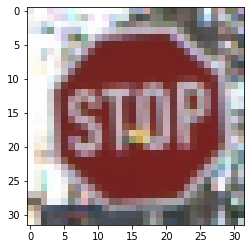

In [0]:
x_train_poison,y_train_poison,x_train_clean,y_train_clean,x_train_backdoor,y_train_backdoor,idx_poison = PoisonGTSB(trainX,trainY,targetLabel=5,p=0.005)
x_test_poison,y_test_poison,x_test_clean,y_test_clean,x_test_backdoor,y_test_backdoor,idx_poison  = PoisonGTSB(testX,testY,targetLabel=5)

img = x_train_backdoor[8]

cv2.imwrite('/content/clean_german_sign.png',x_train_backdoor[8]*255)
plt.show()
plt.imshow(x_train_clean[8])
plt.savefig('/content/poison_german_sign.png')
plt.show()

## Poison Softmax and RBF models with percentages of the 80 km/hr class being poisoned

In [0]:
def detect_clean_data(prediction, poison_idx, x_poison,y_poison,a):
  confidence = prediction[np.arange(prediction.shape[0]),np.argmax(y_poison,axis=1)]
  tp = fp = 0
  total_poison = len(poison_idx)
  total_normal = y_poison.shape[0] - len(poison_idx)
  total = 0
  irq = stats.iqr(confidence)
  q3 = np.quantile(confidence, 0.75)
  thresh = q3 + a*irq
  thresh = a
  idx_dirty = np.where(confidence >= thresh)[0]
  for j in range(len(idx_dirty)):
      if idx_dirty[j] in poison_idx:
          tp += 1.0
  fn = len(poison_idx) - tp
  fp = len(idx_dirty) - tp
  tn = len(y_poison) - tp - fp - fn
  return tp,fp,tn,fn

probs = [0.005,0.01,0.02,0.03,0.04]
correctness_all_test_data = []
correctness_poison_test_data = []
true_positives = []
false_positives = []
false_negatives = []
true_negatives = []
correctness_all_train_data = []
predictions_train = np.zeros((len(probs),60000,10))
restart = False
i = 0
various_ps = []
x_test_poison,y_test_poison,x_test_clean,y_test_clean,x_test_backdoor,y_test_backdoor,idx_poison  = PoisonGTSB(testX,testY,targetLabel=5,p=0.1)
for p in probs:
  # generate poison data
  x_train_poison,y_train_poison,x_train_clean,y_train_clean,x_train_backdoor,y_train_backdoor,poisoned_idx_train = PoisonGTSB(trainX,trainY,targetLabel=5,p=p)
  print('Number of poisoned:',len(poisoned_idx_train))
  ################################################################################################################### softmax train
  softmax_poison = ResNetV1(RBF=False)
  if not restart and os.path.isfile(os.path.join(baseDir_GTSB,'model'+str(p)+'.h5')):
    softmax_poison.load(os.path.join(baseDir_GTSB,'model'+str(p)+'.h5'))
  else:
    softmax_poison.train(x_train_poison,y_train_poison,saveTo=os.path.join(baseDir_GTSB,'model'+str(p)+'.h5'),epochs=4)
  ##################################################################################################################### get predictions
  predictions = np.argmax(softmax_poison.predict(x_test_backdoor),axis=1)
  labels = np.argmax(y_test_backdoor,axis=1)
  acc_reg_poison = np.sum(predictions == labels)/len(labels)
  print('Poison success',acc_reg_poison)
  predictions = np.argmax(softmax_poison.predict(x_train_poison),axis=1)
  labels = np.argmax(y_train_poison,axis=1)
  acc_train_reg = np.sum(predictions == labels)/len(labels)

  predictions = np.argmax(softmax_poison.predict(x_test_poison),axis=1)
  labels = np.argmax(y_test_poison,axis=1)
  acc_reg_clean = np.sum(predictions == labels)/len(labels)
  print('Test accuracy',acc_reg_clean)

  # perform activation clustering defense
  classifier = KerasClassifier(model=softmax_poison.model)
  defence = ActivationDefence(classifier, x_train_poison, y_train_poison)
  report, is_clean_lst = defence.detect_poison(nb_clusters=2,
                                              nb_dims=10,
                                              reduce="PCA")
  # calculate tp,fp,tn,fn
  attempt_idx = np.sort(np.where(np.array(is_clean_lst)== 0)[0])
  poison_idx_sort = np.sort(poisoned_idx_train)
  # calculate true positive
  tp_reg = 0.0
  for idx in attempt_idx:
      if idx in poison_idx_sort:
          tp_reg += 1.0
  fn_reg = len(poison_idx_sort) - tp_reg
  fp_reg = len(attempt_idx) - tp_reg
  tn_reg = y_train_poison.shape[0] - fn_reg - fp_reg - tp_reg

  print('Results (tp,fp,tn,fn)',tp_reg,fp_reg,tn_reg,fn_reg)


  ################################################################################################################################### train anomaly
  anomaly_poison = ResNetV1(anomalyDetector=True)
  if not restart and os.path.isfile(os.path.join(baseDir_GTSB,'poison'+str(p)+'.h5')):
    anomaly_poison.load(os.path.join(baseDir_GTSB,'poison'+str(p)+'.h5'))
  else:
    anomaly_poison.train(x_train_poison,y_train_poison,saveTo=os.path.join(baseDir_GTSB,'poison'+str(p)+'.h5'),epochs=4)
  ##################################################################################################################### get predictions

  predictions = np.argmax(anomaly_poison.predict(x_test_backdoor),axis=1)
  labels = np.argmax(y_test_backdoor,axis=1)
  acc_rbf_poison = np.sum(predictions == labels)/len(labels)
  print('Poison success',acc_rbf_poison)

  predictions = np.argmax(anomaly_poison.predict(x_test_poison),axis=1)
  labels = np.argmax(y_test_poison,axis=1)
  acc_rbf_clean = np.sum(predictions == labels)/len(labels)
  print('Test accuracy',acc_rbf_clean)

  confidence = anomaly_poison.predict(x_train_poison)
  # predictions_train[i,:,:] = confidence
  i += 1
  predictions = np.argmax(confidence,axis=1)
  labels = np.argmax(y_train_poison,axis=1)
  acc_train_rbf = np.sum(predictions == labels)/len(labels)
  tp_rbf,fp_rbf,tn_rbf,fn_rbf = detect_clean_data(confidence, poisoned_idx_train, x_train_poison,y_train_poison,1.5)

  correctness_all_test_data.append([acc_reg_clean,acc_rbf_clean])
  correctness_poison_test_data.append([acc_reg_poison,acc_rbf_poison])
  true_positives.append([tp_reg,tp_rbf])
  false_positives.append([fp_reg,fp_rbf])
  false_negatives.append([fn_reg,fn_rbf])
  true_negatives.append([tn_reg,tn_rbf])
  correctness_all_train_data.append([acc_train_reg,acc_train_rbf])

np.save(os.path.join(baseDir_GTSB,'tp.npy'),true_positives)
np.save(os.path.join(baseDir_GTSB,'fn.npy'),false_negatives)
np.save(os.path.join(baseDir_GTSB,'tn.npy'),true_negatives)
np.save(os.path.join(baseDir_GTSB,'fp.npy'),false_positives)
np.save(os.path.join(baseDir_GTSB,'acc_clean.npy'),correctness_all_test_data)
np.save(os.path.join(baseDir_GTSB,'acc_poison.npy'),correctness_poison_test_data)
np.save(os.path.join(baseDir_GTSB,'acc_train.npy'),correctness_all_train_data)
np.save(os.path.join(baseDir_GTSB,'predictions_anomaly_train.npy'),predictions_train)
np.save(os.path.join(baseDir_GTSB,'various_ps.npy'),various_ps)

## Compute the ROC (Receiver Operator Characteristics) for the RBF Outlier Detection Method

In [0]:
probs = [0.005,0.01,0.02,0.03,0.04]
alphas = np.linspace(0,5,30)
results = []
IRQS = []
results_IRQS= []
i = 0
anomaly_poison = ResNetV1(anomalyDetector=True)
for p in probs:
  print(p)
  x_train_poison,y_train_poison,x_train_clean,y_train_clean,x_train_backdoor,y_train_backdoor,poisoned_idx_train = PoisonGTSB(trainX,trainY,targetLabel=5,p=p)
  anomaly_poison.load(os.path.join(baseDir_GTSB,'poison'+str(p)+'.h5'))
  x_train_backdoor = x_train_poison[poisoned_idx_train]
  y_train_backdoor = y_train_poison[poisoned_idx_train]
  indices = np.arange(y_train_poison.shape[0])
  cleanIdx = np.delete(indices,poisoned_idx_train,axis=0)
  x_train_clean = x_train_poison[cleanIdx]
  y_train_clean = y_train_poison[cleanIdx]
  predictions = anomaly_poison.model.predict(x_train_poison)
  confidence = predictions[np.arange(predictions.shape[0]),np.argmax(y_train_poison,axis=1)]
  irq = stats.iqr(confidence)
  q3 = np.quantile(confidence, 0.75)
  thresh = q3 + 1.5*irq
  IRQS.append(thresh)
  for a in alphas:
    tp_rbf,fp_rbf,tn_rbf,fn_rbf = detect_clean_data(predictions,poisoned_idx_train,x_train_poison,y_train_poison,a)
    results.append([tp_rbf,fp_rbf,tn_rbf,fn_rbf])
  tp_rbf,fp_rbf,tn_rbf,fn_rbf = detect_clean_data(predictions,poisoned_idx_train,x_train_poison,y_train_poison,thresh)
  results_IRQS.append([tp_rbf,fp_rbf,tn_rbf,fn_rbf])
  i += 1
np.save(os.path.join(baseDir_GTSB,'results.npy'),results)

# MNIST Poisoning Attack

## Poison various percentages of the training data set

In [0]:
(x_train, y_train), (x_test, y_test), min_pixel_value, max_pixel_value = load_mnist()
probs = [0.03,0.04,0.05,0.06,0.07, 0.08,0.1,0.13,0.15,0.25]
correctness_all_test_data = []
correctness_poison_test_data = []
true_positives = []
false_positives = []
false_negatives = []
true_negatives = []
correctness_all_train_data = []
predictions_train = np.zeros((len(probs),60000,10))
restart = False
i = 0
various_ps = []
x_test_poison,y_test_poison,poisoned_idx = PoisonMNIST(X=x_test,
                                                Y = y_test,
                                                p=0.1)
x_backdoor = x_test_poison[poisoned_idx]
y_backdoor = y_test_poison[poisoned_idx]
for p in probs:
  # generate poison data
  x_train_poison,y_train_poison,poisoned_idx_train = PoisonMNIST(X=x_train,
                                                Y = y_train,
                                                p=p)
  x_train_backdoor = x_train_poison[poisoned_idx_train]
  y_train_backdoor = y_train_poison[poisoned_idx_train]
  indices = np.arange(y_train_poison.shape[0])
  cleanIdx = np.delete(indices,poisoned_idx_train,axis=0)
  x_train_clean = x_train_poison[cleanIdx]
  y_train_clean = y_train_poison[cleanIdx]
  print('Number of poisoned:',len(poisoned_idx_train))

  softmax_poison = MNISTModel(RBF=False)
  if not restart and os.path.isfile(os.path.join(baseDir_MNIST,'model'+str(p)+'.h5')):
    softmax_poison.load(os.path.join(baseDir_MNIST,'model'+str(p)+'.h5'))
  else:
    softmax_poison.train(x_train_poison,y_train_poison,saveTo=os.path.join(baseDir_MNIST,'model'+str(p)+'.h5'),epochs=5)
  predictions = np.argmax(softmax_poison.predict(x_backdoor),axis=1)
  labels = np.argmax(y_backdoor,axis=1)
  acc_reg_poison = np.sum(predictions == labels)/len(labels)
  print('Poison success',acc_reg_poison)
  predictions = np.argmax(softmax_poison.predict(x_train_poison),axis=1)
  labels = np.argmax(y_train_poison,axis=1)
  acc_train_reg = np.sum(predictions == labels)/len(labels)

  predictions = np.argmax(softmax_poison.predict(x_test_poison),axis=1)
  labels = np.argmax(y_test_poison,axis=1)
  acc_reg_clean = np.sum(predictions == labels)/len(labels)
  print('Test accuracy',acc_reg_clean)

  # perform activation clustering defense
  classifier = KerasClassifier(model=softmax_poison.model)
  defence = ActivationDefence(classifier, x_train_poison, y_train_poison)
  report, is_clean_lst = defence.detect_poison(nb_clusters=2,
                                              nb_dims=10,
                                              reduce="PCA")
  # calculate tp,fp,tn,fn
  attempt_idx = np.sort(np.where(np.array(is_clean_lst)== 0)[0])
  poison_idx_sort = np.sort(poisoned_idx_train)
  # calculate true positive
  tp_reg = 0.0
  for idx in attempt_idx:
      if idx in poison_idx_sort:
          tp_reg += 1.0
  fn_reg = len(poison_idx_sort) - tp_reg
  fp_reg = len(attempt_idx) - tp_reg
  tn_reg = y_train_poison.shape[0] - fn_reg - fp_reg - tp_reg

  print('Results (tp,fp,tn,fn)',tp_reg,fp_reg,tn_reg,fn_reg)

  # train anomaly on feature space of poisoned model
  anomaly_poison = MNISTModel(anomalyDetector=True)
  if not restart and os.path.isfile(os.path.join(baseDir_MNIST,'poison'+str(p)+'.h5')):
    anomaly_poison.load(os.path.join(baseDir_MNIST,'poison'+str(p)+'.h5'))
  else:
    anomaly_poison.train(x_train_poison,y_train_poison,saveTo=os.path.join(baseDir_MNIST,'poison'+str(p)+'.h5'),epochs=10)
  predictions = np.argmax(anomaly_poison.predict(x_backdoor),axis=1)
  labels = np.argmax(y_backdoor,axis=1)
  acc_rbf_poison = np.sum(predictions == labels)/len(labels)
  print('Poison success',acc_rbf_poison)

  predictions = np.argmax(anomaly_poison.predict(x_test_poison),axis=1)
  labels = np.argmax(y_test_poison,axis=1)
  acc_rbf_clean = np.sum(predictions == labels)/len(labels)
  print('Test accuracy',acc_rbf_clean)

  confidence = anomaly_poison.predict(x_train_poison)
  predictions_train[i,:,:] = confidence
  i += 1
  predictions = np.argmax(confidence,axis=1)
  labels = np.argmax(y_train_poison,axis=1)
  acc_train_rbf = np.sum(predictions == labels)/len(labels)

  for quantile in [0.5,0.6,0.7,0.8,0.9]:
    tp_rbf,fp_rbf,tn_rbf,fn_rbf = detect_clean_data(anomaly_poison, poisoned_idx_train, x_train_poison,y_train_poison,quantile)
    various_ps.append([tp_rbf,fp_rbf,tn_rbf,fn_rbf])
  print('Results (tp,fp,tn,fn)',tp_rbf,fp_rbf,tn_rbf,fn_rbf)

  correctness_all_test_data.append([acc_reg_clean,acc_rbf_clean])
  correctness_poison_test_data.append([acc_reg_poison,acc_rbf_poison])
  true_positives.append([tp_reg,tp_rbf])
  false_positives.append([fp_reg,fp_rbf])
  false_negatives.append([fn_reg,fn_rbf])
  true_negatives.append([tn_reg,tn_rbf])
  correctness_all_train_data.append([acc_train_reg,acc_train_rbf])

np.save(os.path.join(baseDir_MNIST,'tp.npy'),true_positives)
np.save(os.path.join(baseDir_MNIST,'fn.npy'),false_negatives)
np.save(os.path.join(baseDir_MNIST,'tn.npy'),true_negatives)
np.save(os.path.join(baseDir_MNIST,'fp.npy'),false_positives)
np.save(os.path.join(baseDir_MNIST,'acc_clean.npy'),correctness_all_test_data)
np.save(os.path.join(baseDir_MNIST,'acc_poison.npy'),correctness_poison_test_data)
np.save(os.path.join(baseDir_MNIST,'acc_train.npy'),correctness_all_train_data)
np.save(os.path.join(baseDir_MNIST,'predictions_anomaly_train.npy'),predictions_train)
np.save(os.path.join(baseDir_MNIST,'various_ps.npy'),various_ps)

Number of poisoned: 1800
Train on 48000 samples, validate on 12000 samples
Epoch 1/5
16416/48000 [=========>....................] - ETA: 7s - loss: 0.5943 - accuracy: 0.8481

KeyboardInterrupt: ignored

## Compute ROC Curve

In [0]:
predictions_train = np.load(os.path.join(baseDir_MNIST,'predictions_anomaly_train.npy'))
alphas = np.linspace(0,5,30)
results = []
IRQS = []
results_IRQS= []
i = 0
anomaly_poison = MNISTModel(anomalyDetector=True)
for p in probs:
  print(p)
  x_train_poison,y_train_poison,poisoned_idx_train = PoisonMNIST(X=x_train,
                                                Y = y_train,
                                                p=p)
  anomaly_poison.load(os.path.join(baseDir_MNIST,'poison'+str(p)+'.h5'))
  x_train_backdoor = x_train_poison[poisoned_idx_train]
  y_train_backdoor = y_train_poison[poisoned_idx_train]
  indices = np.arange(y_train_poison.shape[0])
  cleanIdx = np.delete(indices,poisoned_idx_train,axis=0)
  x_train_clean = x_train_poison[cleanIdx]
  y_train_clean = y_train_poison[cleanIdx]
  predictions = anomaly_poison.model.predict(x_train_poison)
  confidence = predictions[np.arange(predictions.shape[0]),np.argmax(y_train_poison,axis=1)]
  irq = stats.iqr(confidence)
  q3 = np.quantile(confidence, 0.75)
  thresh = q3 + 1.5*irq
  IRQS.append(thresh)
  for a in alphas:
    tp_rbf,fp_rbf,tn_rbf,fn_rbf = detect_clean_data(predictions,poisoned_idx_train,x_train_poison,y_train_poison,a)
    results.append([tp_rbf,fp_rbf,tn_rbf,fn_rbf])
  tp_rbf,fp_rbf,tn_rbf,fn_rbf = detect_clean_data(predictions,poisoned_idx_train,x_train_poison,y_train_poison,thresh)
  results_IRQS.append([tp_rbf,fp_rbf,tn_rbf,fn_rbf])
  i += 1
np.save(os.path.join(baseDir_MNIST,'results.npy'),results)

# Visualizations

In [0]:
! mkdir ./images


## Visualize the ROC Curve for both attacks

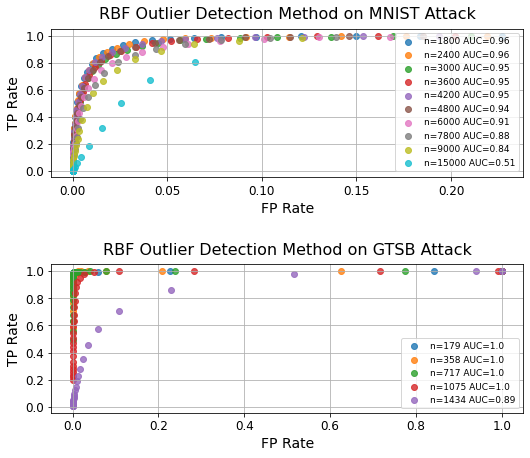

In [0]:
import sklearn
results = np.load(os.path.join(baseDir_GTSB,'results.npy'))
results = np.array(results)
probs = [0.005,0.01,0.02,0.03,0.04]
alphas = np.linspace(0,5,30)
TP = results[:,0]
FP = results[:,1]
TN = results[:,2]
FN = results[:,3]
TP_rate = TP / (TP + FN)
FP_rate = FP / (TN + FP)
plt.figure(figsize=(8,7))
plt.subplot(2,1,2)
for i in range(len(probs)):
  tp_rate = TP_rate[i*len(alphas):(i+1)*len(alphas)]
  fp_rate = FP_rate[i*len(alphas):(i+1)*len(alphas)]
  n = int(35856*probs[i])
  auc = sklearn.metrics.auc(fp_rate,tp_rate)/np.ptp(fp_rate)
  label = 'n='+str(n)+' AUC='+str(np.round(auc,2))
  plt.scatter(fp_rate,tp_rate,label=label,alpha=0.8)
plt.xlabel('FP Rate',fontsize=14)
plt.ylabel('TP Rate',fontsize=14)
plt.title('RBF Outlier Detection Method on GTSB Attack',fontsize=16,pad=10)
plt.legend(prop={'size': 9})
plt.grid(True)
plt.tick_params(axis='both',labelsize = 12)
plt.subplot(2,1,1)

results = np.load(os.path.join(baseDir_MNIST,'results.npy'))
results = np.array(results)
probs = [0.03,0.04,0.05,0.06,0.07, 0.08,0.1,0.13,0.15,0.25]
alphas = np.linspace(0,5,30)
TP = results[:,0]
FP = results[:,1]
TN = results[:,2]
FN = results[:,3]
TP_rate = TP / (TP + FN)
FP_rate = FP / (TN + FP)
for i in range(len(probs)):
  tp_rate = TP_rate[i*len(alphas):(i+1)*len(alphas)]
  fp_rate = FP_rate[i*len(alphas):(i+1)*len(alphas)]
  n = int(60000*probs[i])
  auc = sklearn.metrics.auc(fp_rate,tp_rate)/np.ptp(fp_rate)
  label = 'n='+str(n)+' AUC='+str(np.round(auc,2))
  plt.scatter(fp_rate,tp_rate,label=label,alpha=0.8)
plt.xlabel('FP Rate',fontsize=14)
plt.ylabel('TP Rate',fontsize=14)
plt.title('RBF Outlier Detection Method on MNIST Attack',fontsize=16,pad=10)
plt.legend(prop={'size': 9})
plt.grid(True)
#plt.suptitle("RBF Outlier Detection Method ROC Curve", fontsize=18)
plt.tight_layout(pad=3)
plt.tick_params(axis='both',labelsize = 12)
#plt.subplots_adjust(top=0.82)
plt.savefig('./images/ROC2.eps', format='eps', dpi=1000)


## Compare with the outlier detection method

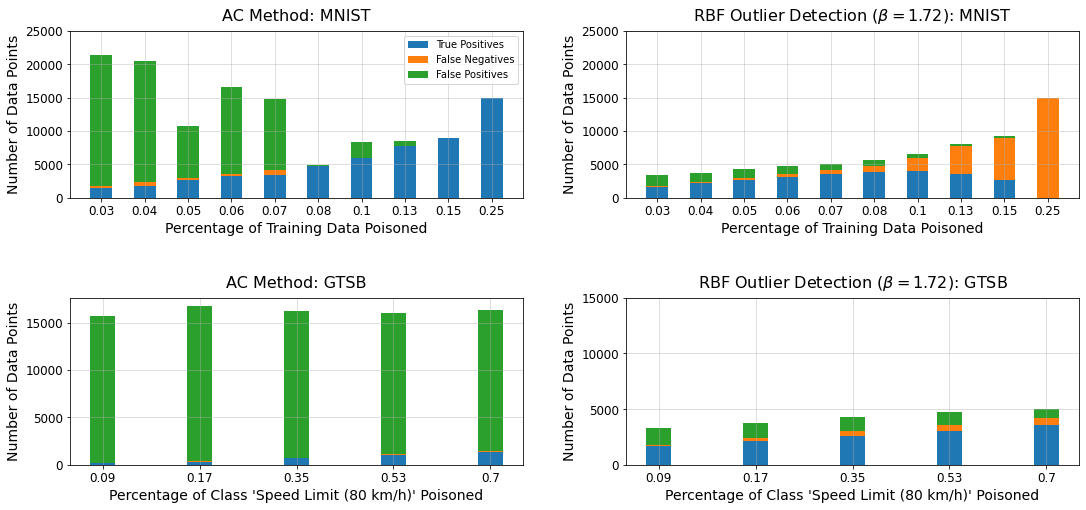

In [0]:
probs = [0.005,0.01,0.02,0.03,0.04]
alphas = np.linspace(0,5,30)
true_positives = np.load(os.path.join(baseDir_GTSB,'tp.npy'))[:,0]
false_negatives = np.load(os.path.join(baseDir_GTSB,'fn.npy'))[:,0]
true_negatives = np.load(os.path.join(baseDir_GTSB,'tn.npy'))[:,0]
false_positives = np.load(os.path.join(baseDir_GTSB,'fp.npy'))[:,0]
sensitivity = true_positives / (true_positives + false_negatives)
specificity = true_negatives / (true_negatives + false_positives)
false_positive = false_positives / (true_negatives + false_positives)

class_size = np.sum(np.argmax(y_train_poison,1)==5)
n = [int(p*35856) for p in probs]
ind = np.arange(len(probs))
width = 0.25


fig = plt.figure(figsize=(16,8))
plt.subplot(2,2,3)
plt.bar(ind,true_positives,width,label='True Positives')
plt.bar(ind,false_negatives,width,bottom=true_positives,label='False Negatives')
plt.bar(ind,false_positives,width,bottom=false_negatives+true_positives,label='False Positives')
plt.ylabel('Number of Data Points',fontsize=14)
plt.xlabel('Percentage of Class \'Speed Limit (80 km/h)\' Poisoned',fontsize=14)
plt.title(r'AC Method: GTSB',fontsize=16,pad=10)

probs_string = [np.round(int(p*35856)/class_size,2) for p in probs]
probs_string = tuple(probs_string)
plt.xticks(ind, probs_string)
plt.yticks(np.arange(0, 20000, 5000))
plt.grid(True,alpha=0.5)
plt.tick_params(axis='both',labelsize = 12)

plt.grid(True)

j = 10
thresh = np.round(alphas[j],2)
idx = [i*30+j for i in range(len(probs))]
TP = results[:,0]
FP = results[:,1]
TN = results[:,2]
FN = results[:,3]

plt.subplot(2,2,4)
plt.bar(ind,TP[idx],width,label='True Positives')
plt.bar(ind,FN[idx],width,bottom=TP[idx],label='False Negatives')
#plt.bar(ind,true_negatives,width,bottom=false_negatives+true_positives,label='True Negatives')
plt.bar(ind,FP[idx],width,bottom=FN[idx]+TP[idx],label='False Positives')
plt.ylabel('Number of Data Points',fontsize=14)
plt.xlabel('Percentage of Class \'Speed Limit (80 km/h)\' Poisoned',fontsize=14)
plt.title(r'RBF Outlier Detection ($\beta='+str(thresh)+'$): GTSB',fontsize=16,pad=10)

probs_string = [np.round(int(p*35856)/class_size,2) for p in probs]
probs_string = tuple(probs_string)
plt.xticks(ind, probs_string)
plt.yticks(np.arange(0, 20000, 5000))
plt.grid(True,alpha=0.5)
plt.tick_params(axis='both',labelsize = 12)

probs = [0.03,0.04,0.05,0.06,0.07, 0.08,0.1,0.13,0.15,0.25]

true_positives = np.load(os.path.join(baseDir_MNIST,'tp.npy'))[:,0]
false_negatives = np.load(os.path.join(baseDir_MNIST,'fn.npy'))[:,0]
true_negatives = np.load(os.path.join(baseDir_MNIST,'tn.npy'))[:,0]
false_positives = np.load(os.path.join(baseDir_MNIST,'fp.npy'))[:,0]
false_positive = false_positives / (true_negatives + false_positives)

sensitivity = true_positives / (true_positives + false_negatives)
specificity = true_negatives / (true_negatives + false_positives)
n = [int(p*60000) for p in probs]
ind = np.arange(10)
width = 0.5



plt.subplot(2,2,1)
plt.bar(ind,true_positives,width,label='True Positives')
plt.bar(ind,false_negatives,width,bottom=true_positives,label='False Negatives')
plt.bar(ind,false_positives,width,bottom=false_negatives+true_positives,label='False Positives')
plt.ylabel('Number of Data Points',fontsize=14)
plt.xlabel('Percentage of Training Data Poisoned',fontsize=14)
plt.title(r'AC Method: MNIST',fontsize=16,pad=10)
plt.legend()

probs_string = [str(p) for p in probs]
probs_string = tuple(probs_string)
plt.xticks(ind, probs_string)
plt.yticks(np.arange(0, 30000, 5000))
plt.grid(True,alpha=0.5)
plt.tick_params(axis='both',labelsize = 12)
plt.grid(True)

j = 10
thresh = np.round(alphas[j],2)
idx = [i*30+j for i in range(10)]
TP = results[:,0]
FP = results[:,1]
TN = results[:,2]
FN = results[:,3]

plt.subplot(2,2,2)
plt.bar(ind,TP[idx],width,label='True Positives')
plt.bar(ind,FN[idx],width,bottom=TP[idx],label='False Negatives')
#plt.bar(ind,true_negatives,width,bottom=false_negatives+true_positives,label='True Negatives')
plt.bar(ind,FP[idx],width,bottom=FN[idx]+TP[idx],label='False Positives')
plt.ylabel('Number of Data Points',fontsize=14)
plt.xlabel('Percentage of Training Data Poisoned',fontsize=14)
plt.title(r'RBF Outlier Detection ($\beta='+str(thresh)+'$): MNIST',fontsize=16,pad=10)

probs_string = [str(p) for p in probs]
probs_string = tuple(probs_string)
plt.xticks(ind, probs_string)
plt.yticks(np.arange(0, 30000, 5000))
plt.grid(True,alpha=0.5)
plt.tight_layout(pad=4)
plt.tick_params(axis='both',labelsize = 12)
plt.savefig('./images/poison_cleaning2.pdf', format='pdf', dpi=1000,bbox_inches='tight',facecolor=fig.get_facecolor())

## Show poisoning success rate on RBF

<Figure size 432x288 with 0 Axes>

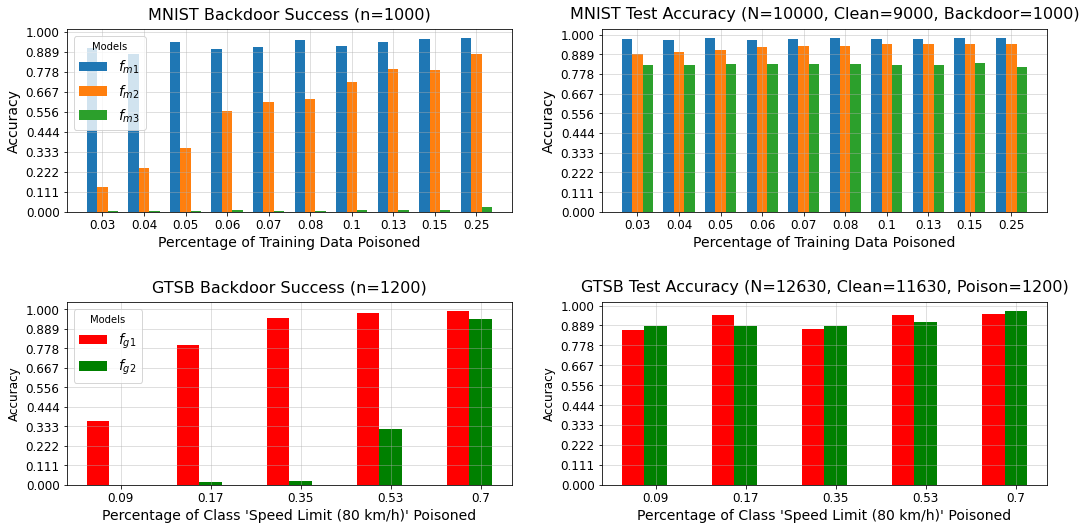

In [0]:
correctness_all_test_data = np.load(os.path.join(baseDir_GTSB,'acc_clean.npy'))
correctness_poison_test_data = np.load(os.path.join(baseDir_GTSB,'acc_poison.npy'))
correctness_all_train_data = np.load(os.path.join(baseDir_GTSB,'acc_train.npy'))

plt.figure()
probs = [0.005,0.01,0.02,0.03,0.04]
# Numbers of pairs of bars you want
N = len(probs)
probs_string = [np.round(int(p*35856)/class_size,2) for p in probs]
probs_string = tuple(probs_string)
# Data on X-axis

# Specify the values of blue bars (height)
blue_bar = [correctness_poison_test_data[i,0] for i in range(len(probs)) ]
# Specify the values of orange bars (height)
orange_bar = [correctness_poison_test_data[i,1] for i in range(len(probs)) ]
# Position of bars on x-axis
ind = np.arange(N)

# Figure size
fig = plt.figure(figsize=(16,8))
plt.subplot(2,2,3)

# Width of a bar 
width = 0.25  
# Plotting
plt.xticks(ind + width, probs_string)
plt.yticks(np.linspace(0,1,10))
plt.bar(ind, blue_bar , width, label=r'$f_{g1}$',color='red')
plt.bar(ind + width, orange_bar, width, label=r'$f_{g2}$',color='green')
plt.ylabel('Accuracy',fontsize=12)
plt.legend(loc='upper left',title='Models',prop={'size': 14})
plt.title('GTSB Backdoor Success (n=1200)',fontsize=16,pad=10)
plt.grid(True,alpha=0.5)
plt.xlabel('Percentage of Class \'Speed Limit (80 km/h)\' Poisoned',fontsize=14)
plt.tick_params(axis='both',labelsize = 12)

# xticks()
# First argument - A list of positions at which ticks should be placed
# Second argument -  A list of labels to place at the given locations

# Finding the best position for legends and putting it
probs_string = [np.round(int(p*35856)/class_size,2) for p in probs]
probs_string = tuple(probs_string)
probs = [0.005,0.01,0.02,0.03,0.04]

# Numbers of pairs of bars you want
N = len(probs)

# Data on X-axis

# Specify the values of blue bars (height)
blue_bar = [correctness_all_test_data[i,0] for i in range(len(probs)) ]
# Specify the values of orange bars (height)
orange_bar = [correctness_all_test_data[i,1] for i in range(len(probs)) ]
# Position of bars on x-axis
ind = np.arange(N)

# Figure size
plt.subplot(2,2,4)
# Width of a bar 
width = 0.25  
# Plotting
plt.xticks(ind + width, probs_string)
plt.yticks(np.linspace(0,1,10))
plt.bar(ind, blue_bar , width, label='ResNet20 w/ Softmax Activation',color='red')
plt.bar(ind + width, orange_bar, width, label='ResNet20 w/ RBF Layer',color='green')
plt.ylabel('Accuracy',fontsize=12)
plt.title('GTSB Test Accuracy (N=12630, Clean=11630, Poison=1200)',fontsize=16,pad=10)
plt.xlabel('Percentage of Class \'Speed Limit (80 km/h)\' Poisoned',fontsize=14)
plt.tick_params(axis='both',labelsize = 12)

# xticks()
# First argument - A list of positions at which ticks should be placed
# Second argument -  A list of labels to place at the given locations

# Finding the best position for legends and putting it
probs_string = [np.round(int(p*35856)/class_size,2) for p in probs]
probs_string = tuple(probs_string)
plt.grid(True,alpha=0.5)

correctness_all_test_data = np.load(os.path.join(baseDir_MNIST,'acc_clean.npy'))
correctness_poison_test_data = np.load(os.path.join(baseDir_MNIST,'acc_poison.npy'))
correctness_all_train_data = np.load(os.path.join(baseDir_MNIST,'acc_train.npy'))

probs = [0.03,0.04,0.05,0.06,0.07, 0.08,0.1,0.13,0.15,0.25]
probs_string = [str(p) for p in probs]
probs_string = tuple(probs_string)
# Numbers of pairs of bars you want
N = len(probs)

# Data on X-axis

# Specify the values of blue bars (height)
blue_bar = [correctness_poison_test_data[i,0] for i in range(len(probs)) ]
# Specify the values of orange bars (height)
orange_bar = [correctness_poison_test_data[i,1] for i in range(len(probs)) ]
green_bar = [correctness_poison_test_data[i,2] for i in range(len(probs)) ]
# Position of bars on x-axis
ind = np.arange(N)

# Figure size
plt.subplot(2,2,1)

# Width of a bar 
width = 0.25  
# Plotting
plt.xticks(ind + width, probs_string)
plt.yticks(np.linspace(0,1,10))
plt.bar(ind, blue_bar , width, label=r'$f_{m1}$')
plt.bar(ind + width, green_bar, width, label=r'$f_{m2}$')
plt.bar(ind + 2*width, orange_bar, width, label=r'$f_{m3}$')
plt.legend(loc='upper left',title='Models',prop={'size': 14})
plt.ylabel('Accuracy',fontsize=14)
plt.title('MNIST Backdoor Success (n=1000)',fontsize=16,pad=10)
plt.grid(True,alpha=0.5)
plt.xlabel('Percentage of Training Data Poisoned',fontsize=14)
plt.tick_params(axis='both',labelsize = 12)

# xticks()
# First argument - A list of positions at which ticks should be placed
# Second argument -  A list of labels to place at the given locations

# Finding the best position for legends and putting it
probs_string = [str(p) for p in probs]
probs_string = tuple(probs_string)
probs = [0.03,0.04,0.05,0.06,0.07, 0.08,0.1,0.13,0.15,0.25]

# Numbers of pairs of bars you want
N = len(probs)

# Data on X-axis

# Specify the values of blue bars (height)
blue_bar = [correctness_all_test_data[i,0] for i in range(len(probs)) ]
# Specify the values of orange bars (height)
orange_bar = [correctness_all_test_data[i,1] for i in range(len(probs)) ]
green_bar = [correctness_all_test_data[i,2] for i in range(len(probs)) ]
# Position of bars on x-axis
ind = np.arange(N)

# Figure size
plt.subplot(2,2,2)
# Width of a bar 
width = 0.25  
# Plotting
plt.xticks(ind + width, probs_string)
plt.yticks(np.linspace(0,1,10))
plt.bar(ind, blue_bar , width, label='Feature Extractor + FC layer + Softmax Activation')
plt.bar(ind + width, green_bar, width, label='Feature Extractor + FC layer + RBF Layer')
plt.bar(ind + 2*width, orange_bar, width, label='Feature Extractor + RBF Layer')
plt.ylabel('Accuracy',fontsize=14)
plt.title('MNIST Test Accuracy (N=10000, Clean=9000, Backdoor=1000)',fontsize=16,pad=10)
plt.xlabel('Percentage of Training Data Poisoned',fontsize=14)
plt.tick_params(axis='both',labelsize = 12)

# xticks()
# First argument - A list of positions at which ticks should be placed
# Second argument -  A list of labels to place at the given locations

# Finding the best position for legends and putting it
probs_string = [str(p) for p in probs]
probs_string = tuple(probs_string)
plt.grid(True,alpha=0.5)
plt.tight_layout(pad=3)
plt.savefig('./images/poison_accuracy2.pdf', format='pdf', dpi=1000,bbox_inches='tight',facecolor=fig.get_facecolor())

